In [1]:
import joblib 
import numpy as np
import pandas as pd 
from pathlib import Path
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [3]:
pythiaA_pkl_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/tmp/pythiaA_pred.pkl'
pythiaA_pkl_path = Path(pythiaA_pkl_path)
pythiaA_pkl = joblib.load(pythiaA_pkl_path)

print(pythiaA_pkl.shape)

In [6]:
pythiaA_pkl.head()

,run,event,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,event_weight,is_forward,is_leading,pt_idx,target,GBDT_newScore
0,364703.0,46193254.0,766.747925,1.298662,2.0,0.318292,0.215923,-0.192873,21.0,17.609434,1.0,1.0,1,1,-1.726218
1,364703.0,46193254.0,701.621765,-0.989431,2.0,0.269898,0.157799,-0.126821,-1.0,17.609434,0.0,0.0,1,-,-1.859249
0,364707.0,15128948.0,1846.887451,0.140206,11.0,0.012225,0.162834,-0.442511,2.0,0.002348,1.0,1.0,5,0,-3.864761
1,364707.0,15128948.0,1820.287109,-0.126045,14.0,0.014112,0.167419,-0.290822,2.0,0.002348,0.0,0.0,5,0,-2.973750
2,364707.0,15304511.0,1927.582397,-0.733196,39.0,0.030777,0.199734,0.295834,21.0,0.004385,1.0,1.0,5,1,0.704581


In [9]:
pythiaA_pkl = pythiaA_pkl[pythiaA_pkl["target"] != '-']
pythiaA_pkl.shape

(55987545, 15)

In [2]:
pythia_pkls = {}
for period in ["A", "D", "E"]:
    pythiaA_pkl_path = f'/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/tmp/pythia{period}_pred.pkl'
    pythiaA_pkl_path = Path(pythiaA_pkl_path)
    pythia_pkls[f'pythia{period}'] = joblib.load(pythiaA_pkl_path)

In [3]:
for pythia_key, pythia_pd in pythia_pkls.items():
    # drop jets with truth parton id == -1 
    pythia_pkls[pythia_key] = pythia_pd[pythia_pd["target"] != '-']


In [35]:
ROC_input_dict = {}
for pythia_key, pythia_pd in pythia_pkls.items():
    ROC_input_dict[pythia_key] = {
        "y_true":pythia_pd['target'].astype(float).values,
        "y_score":pythia_pd['GBDT_newScore'].values,
        "sample_weight":pythia_pd['event_weight'].values,
    }

# ROC

## Inclusive ROC

In [37]:
def plot_ROCs(input_dict, output_path=None, suptitle_pt="Inclusive"):
    fig, ax = plt.subplots()
    for k, v in input_dict.items():
        fpr, tpr, _ = roc_curve(y_true=v["y_true"], y_score=v["y_score"],
                                sample_weight=v["sample_weight"])
        roc_auc = auc(fpr, tpr)
        plt.plot(1-fpr, tpr, lw=1, label=f'ROC {k} (area = {roc_auc:0.3f})')

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower left")
    plt.grid()

    fig.suptitle(f"ROC pt range {suptitle_pt}")

In [29]:
# ROC_input_dict = {}
# ROC_input_dict['pythiaA'] = {
#     "y_true":pythiaA_pkl['target'].astype(float).values,
#     "y_score":pythiaA_pkl['GBDT_newScore'].values,
#     "sample_weight":pythiaA_pkl['event_weight'].values,
# }

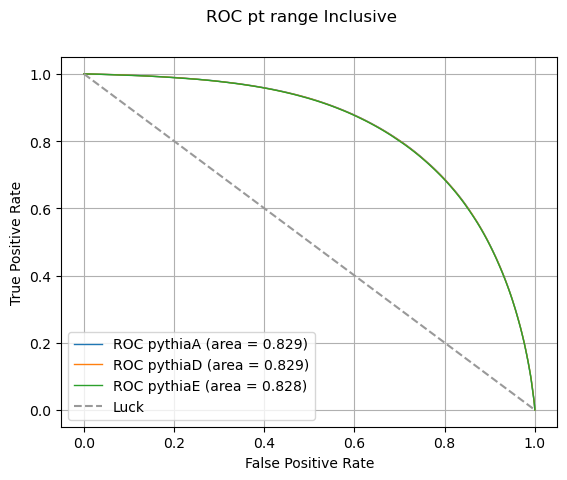

In [38]:
plot_ROCs(ROC_input_dict) # takes 2.5 mins to draw this ROC 

## pt slices ROC 

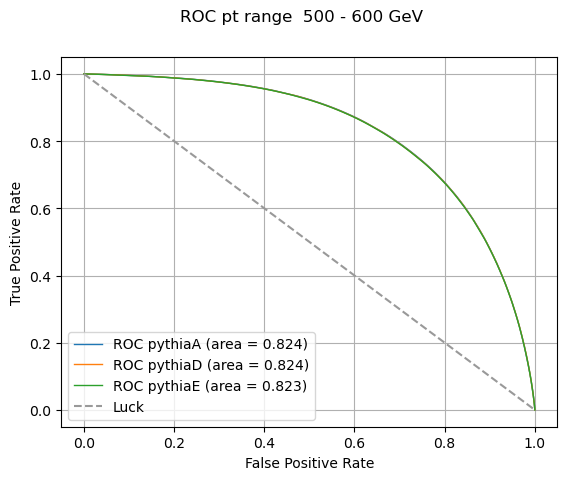

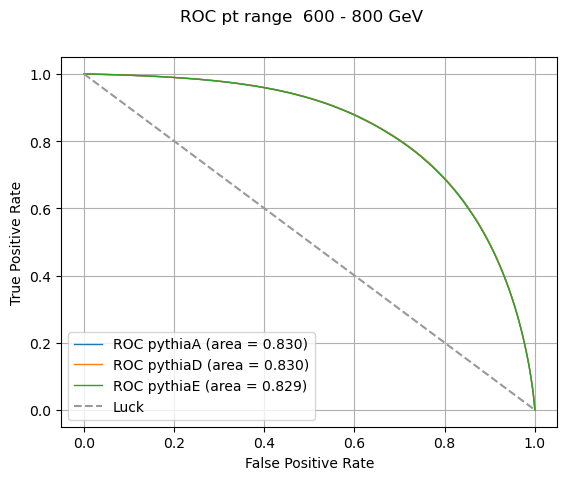

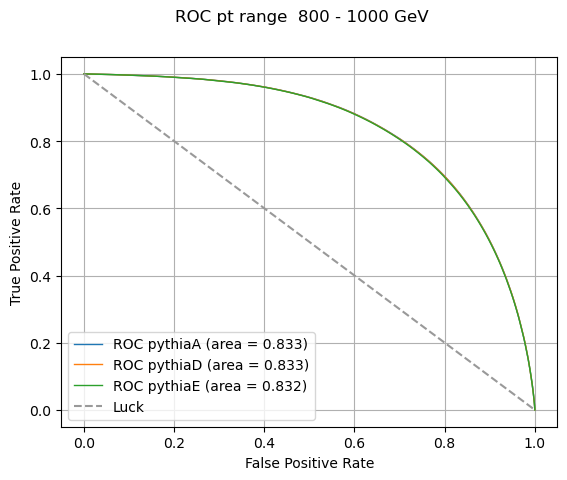

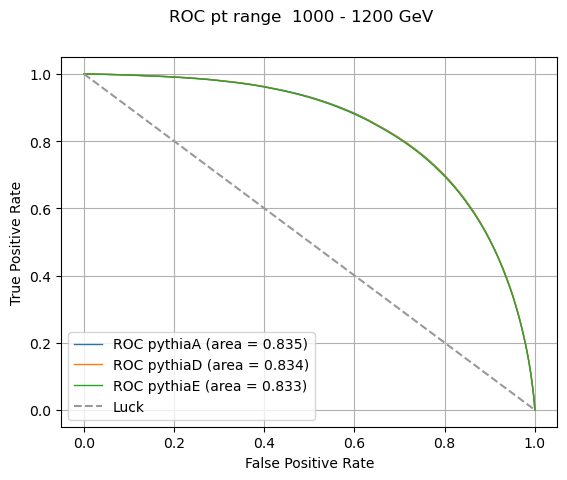

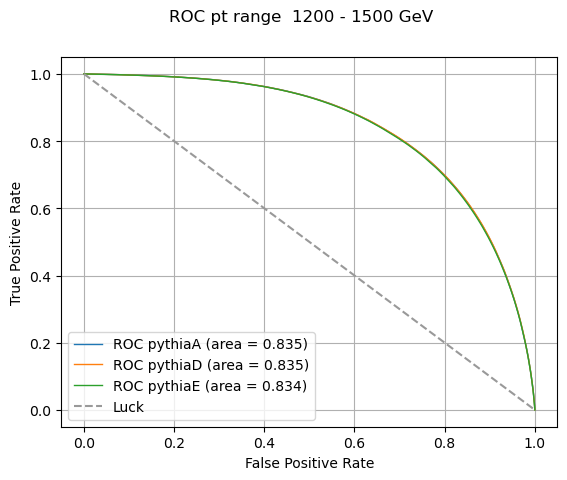

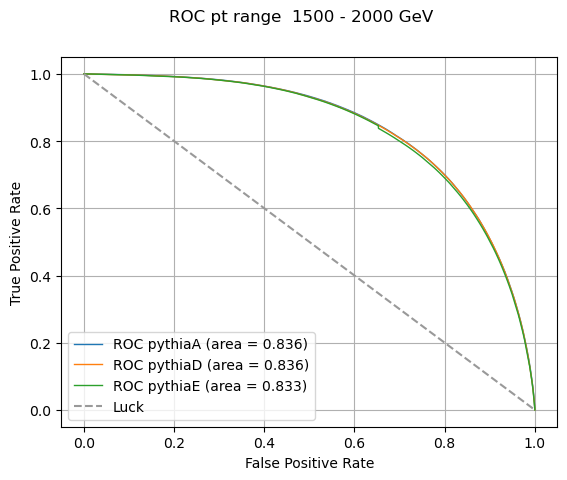

In [40]:
label_pt_bin = np.array([500, 600, 800, 1000, 1200, 1500, 2000])

# This loops on 5 regions, takes 2.5 mins 
ROC_input_dict_at_pt = {}
for pt_idx, l_pt in enumerate(label_pt_bin[:-1]):
    ROC_input_dict_at_pt[pt_idx] = {}

    for pythia_key, pythia_pd in pythia_pkls.items():
        pythia_pd = pythia_pd[pythia_pd['pt_idx'] == pt_idx]
        ROC_input_dict_at_pt[pt_idx][pythia_key] = {
            "y_true":pythia_pd['target'].astype(float).values,
            "y_score":pythia_pd['GBDT_newScore'].values,
            "sample_weight":pythia_pd['event_weight'].values,
        }
    
    plot_ROCs(ROC_input_dict_at_pt[pt_idx], suptitle_pt=f" {l_pt} - {label_pt_bin[pt_idx+1]} GeV") 

# Decision scores

In [41]:
pythiaA_pkl.head()

,run,event,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,event_weight,is_forward,is_leading,pt_idx,target,GBDT_newScore
0,364703.0,46193254.0,766.747925,1.298662,2.0,0.318292,0.215923,-0.192873,21.0,17.609434,1.0,1.0,1,1,-1.726218
0,364707.0,15128948.0,1846.887451,0.140206,11.0,0.012225,0.162834,-0.442511,2.0,0.002348,1.0,1.0,5,0,-3.864761
1,364707.0,15128948.0,1820.287109,-0.126045,14.0,0.014112,0.167419,-0.290822,2.0,0.002348,0.0,0.0,5,0,-2.973750
2,364707.0,15304511.0,1927.582397,-0.733196,39.0,0.030777,0.199734,0.295834,21.0,0.004385,1.0,1.0,5,1,0.704581
3,364707.0,15304511.0,1427.901489,0.236908,37.0,0.126206,0.311115,0.159987,21.0,0.004385,0.0,0.0,4,1,0.019631


In [42]:
score_input_dict = {}
for pythia_key, pythia_pd in pythia_pkls.items():
    score_input_dict[pythia_key] = {
        "quark_score": pythia_pd[pythia_pd["target"]==0]["GBDT_newScore"],
        "quark_weight": pythia_pd[pythia_pd["target"]==0]["event_weight"],
        "gluon_score": pythia_pd[pythia_pd["target"]==1]["GBDT_newScore"],
        "gluon_weight": pythia_pd[pythia_pd["target"]==1]["event_weight"]
    }

In [4]:
def plot_scores(input_dict, output_path=None, suptitle_pt="Inclusive"):
    GBDT_bins = np.linspace(-5, 5, 101)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    for k, v in input_dict.items():
        ax[0].hist(x=v["quark_score"], bins=GBDT_bins, weights=v["quark_weight"], label=k, alpha = 0.5)
        ax[1].hist(x=v["gluon_score"], bins=GBDT_bins, weights=v["gluon_weight"], label=k, alpha = 0.5)
    
    ax[0].legend()
    ax[1].legend()
    fig.suptitle(f"Decision Scores, pt range {suptitle_pt}")


## Inclusive decision scores 

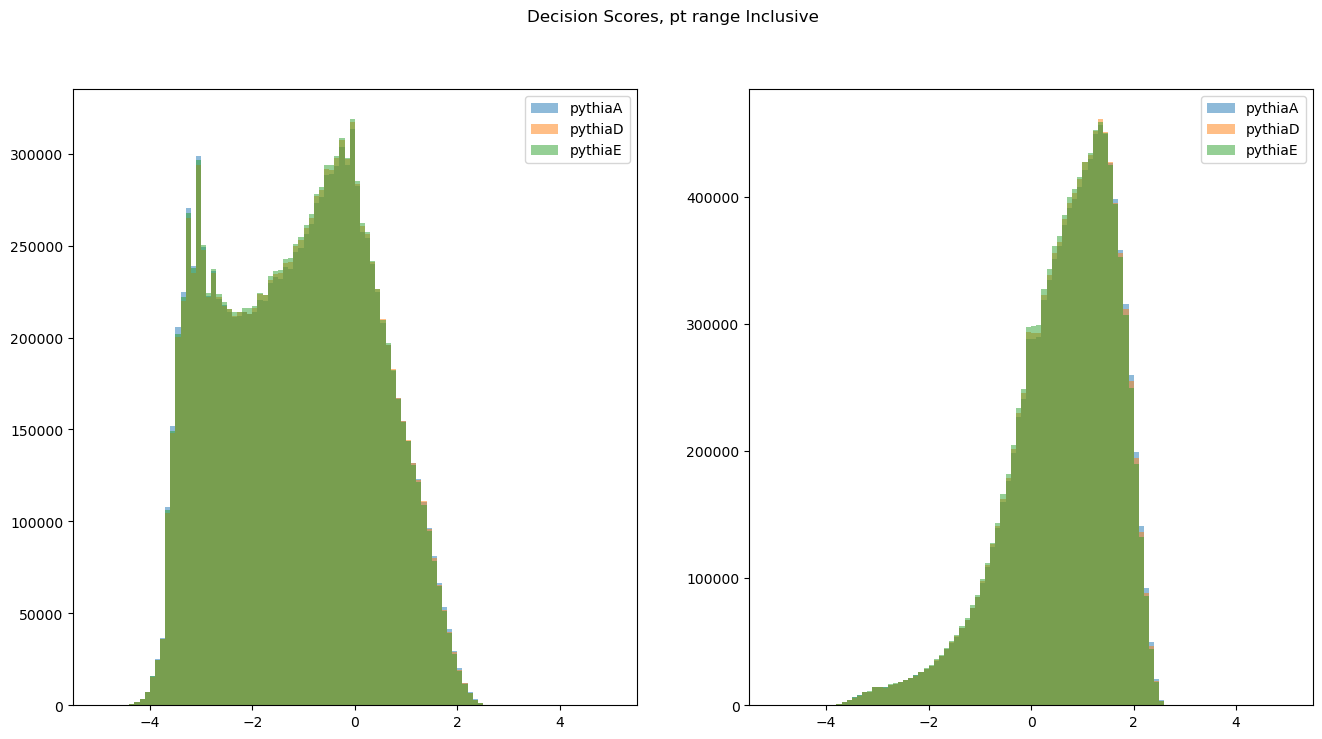

In [46]:
plot_scores(score_input_dict)

## pt slices decision scores 

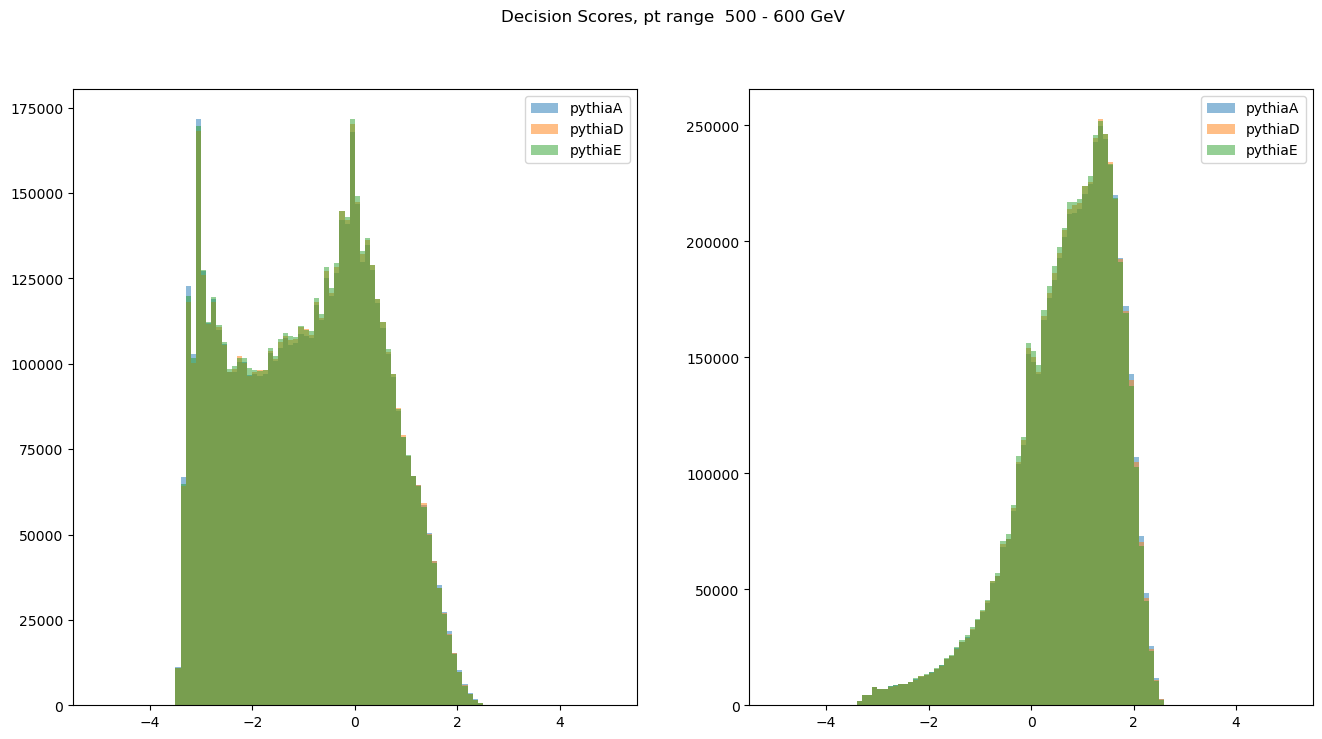

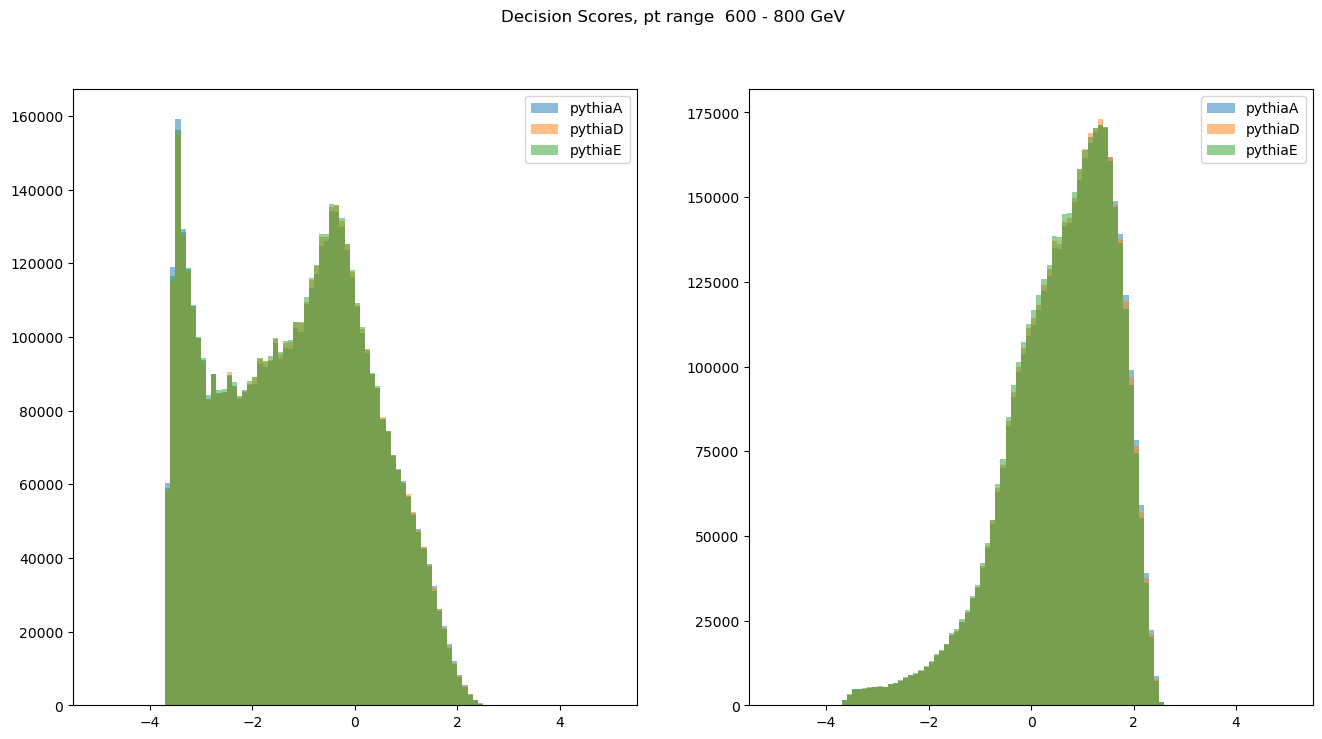

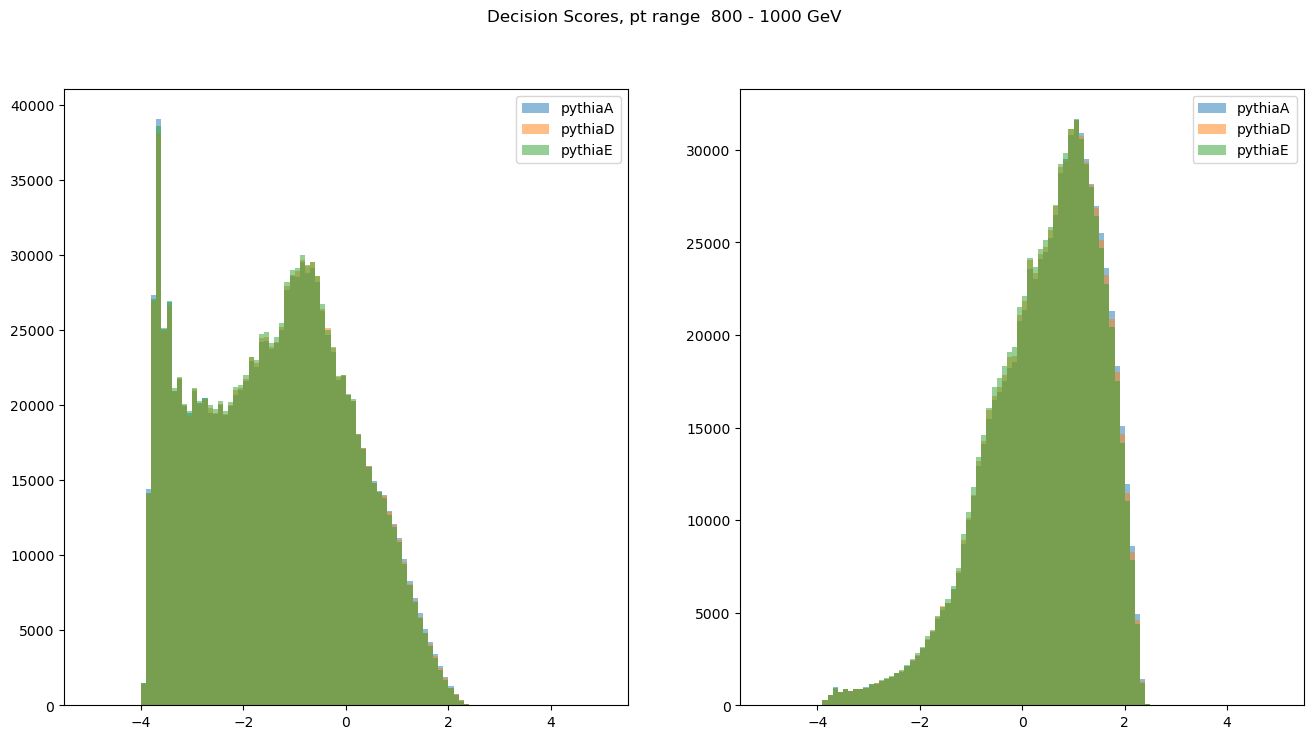

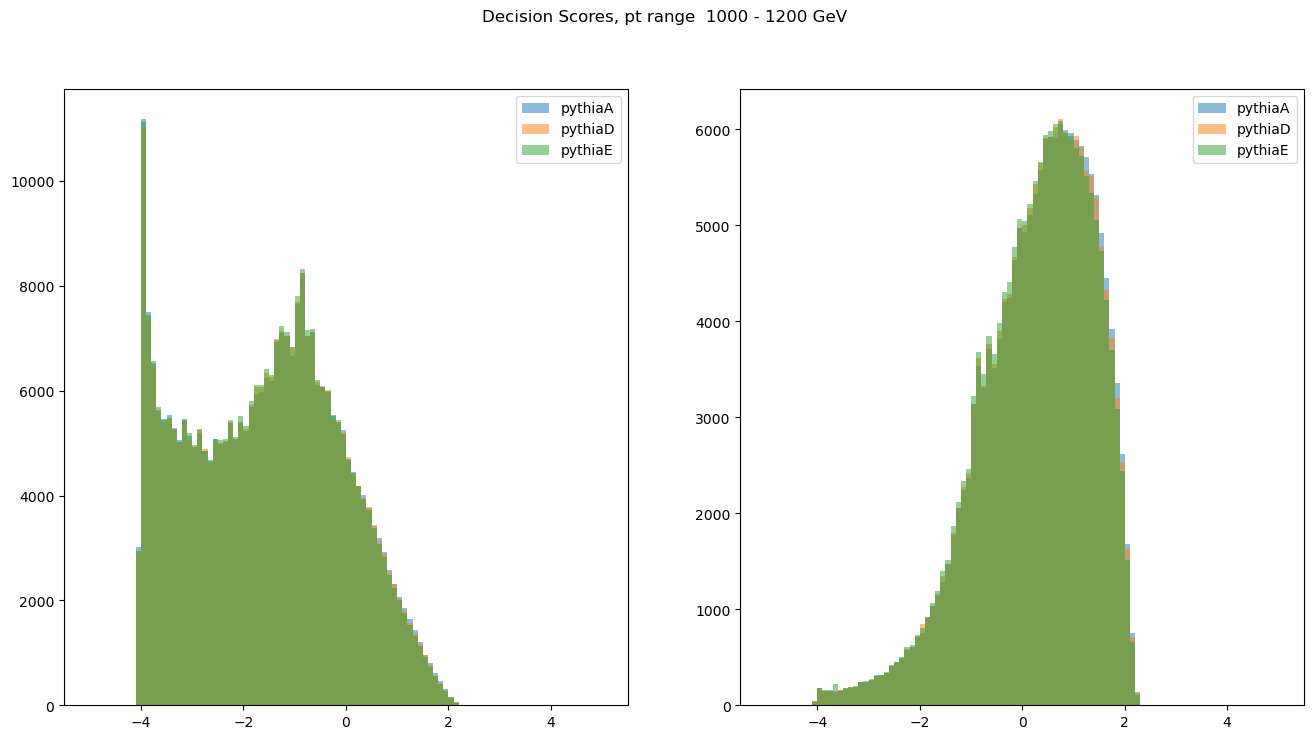

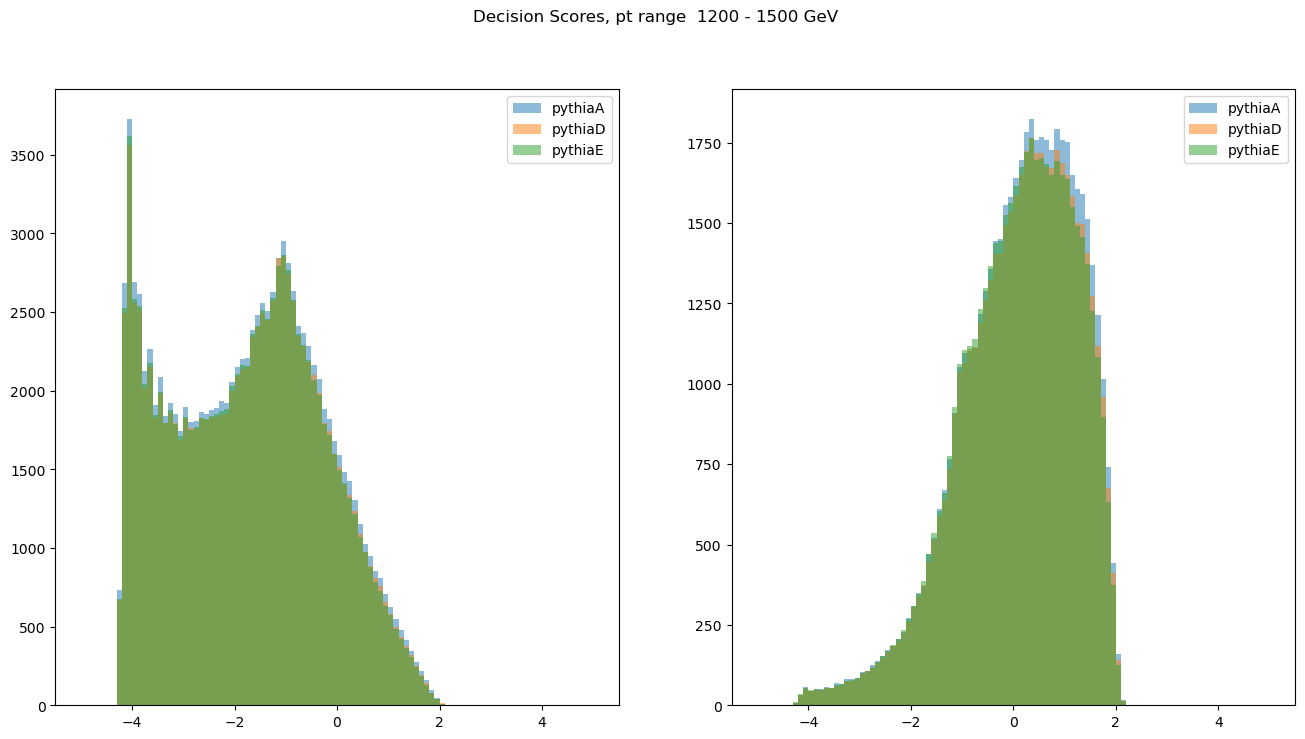

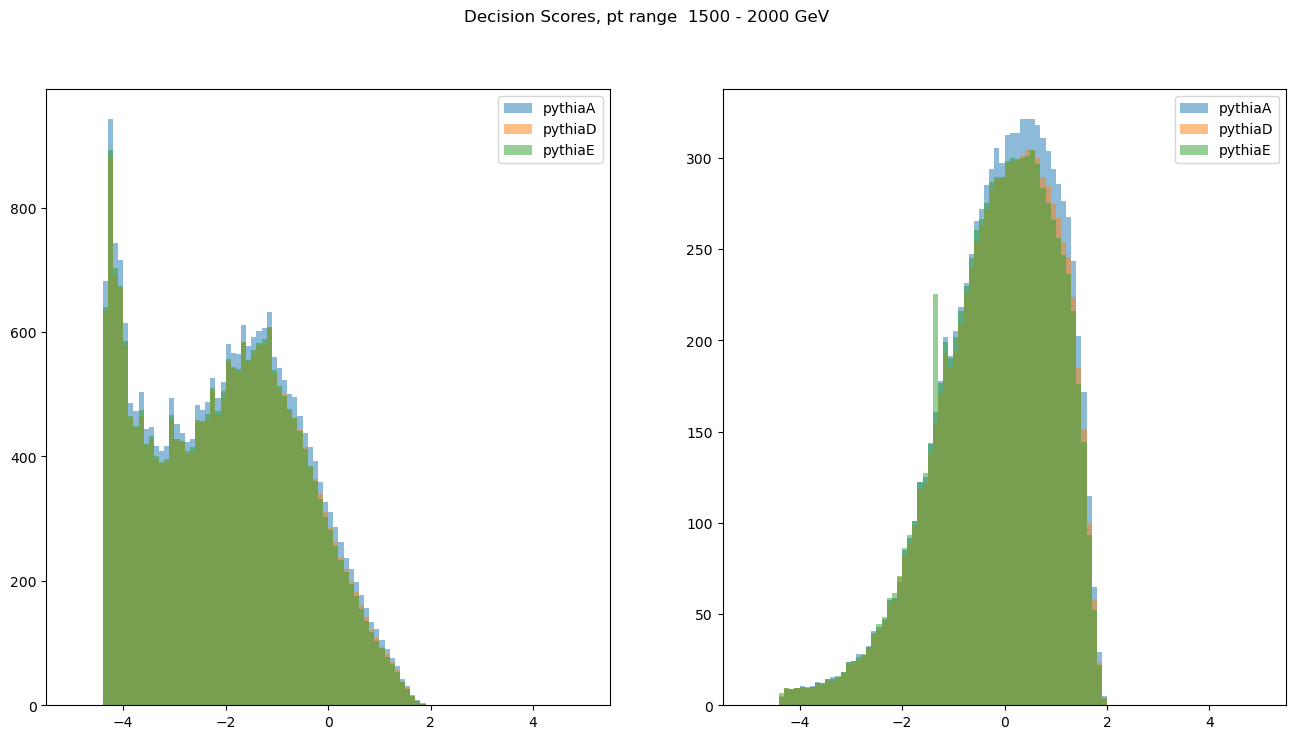

In [6]:
label_pt_bin = np.array([500, 600, 800, 1000, 1200, 1500, 2000])

# This loops on 5 regions, takes 2.5 mins 
score_input_dict_at_pt = {}
for pt_idx, l_pt in enumerate(label_pt_bin[:-1]):
    score_input_dict_at_pt[pt_idx] = {}

    for pythia_key, pythia_pd in pythia_pkls.items():
        pythia_pd = pythia_pd[pythia_pd['pt_idx'] == pt_idx]
        score_input_dict_at_pt[pt_idx][pythia_key] = {
            "quark_score": pythia_pd[pythia_pd["target"]==0]["GBDT_newScore"],
            "quark_weight": pythia_pd[pythia_pd["target"]==0]["event_weight"],
            "gluon_score": pythia_pd[pythia_pd["target"]==1]["GBDT_newScore"],
            "gluon_weight": pythia_pd[pythia_pd["target"]==1]["event_weight"],
        }
    
    plot_scores(score_input_dict_at_pt[pt_idx], suptitle_pt=f" {l_pt} - {label_pt_bin[pt_idx+1]} GeV") 